In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

[*********************100%***********************]  1 of 1 completed


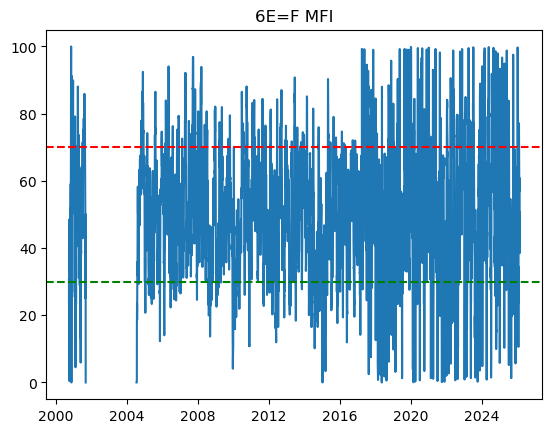

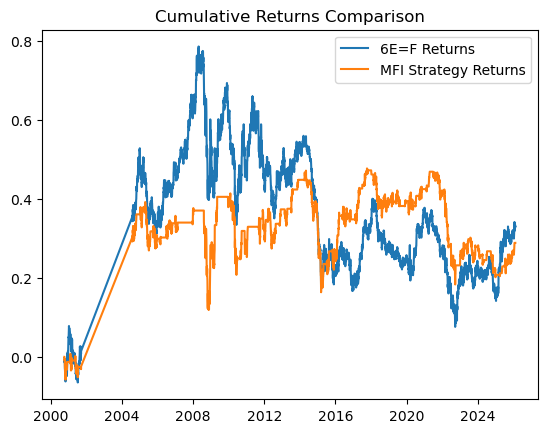

Price,Close,High,Low,Open,Volume,Average_price,Money_flow,Positive_flow,Negative_flow,MFI,signal,strategy,Asset_returns,strategy_returns
Date,,,,,,,,,,,,,,
2000-10-02,0.89350,0.89650,0.89350,0.89530,0,0.894500,0.000000,0.000000,0.000000,30.577663,NaN,NaN,NaN,NaN
2000-10-03,0.88800,0.89650,0.88800,0.89350,5,0.890833,4.454167,0.000000,4.454167,30.409785,NaN,0.0,-0.006156,0.000000
2000-10-04,0.88900,0.88900,0.88700,0.88900,5,0.888333,4.441667,0.000000,4.441667,23.684950,1.0,0.0,-0.005036,0.000000
2000-10-05,0.88800,0.88900,0.88800,0.88900,1,0.888333,0.888333,0.000000,0.000000,27.179426,1.0,1.0,-0.006156,-0.001125
2000-10-06,0.88080,0.88300,0.88100,0.88250,1,0.881600,0.881600,0.000000,0.881600,31.816030,NaN,1.0,-0.014214,-0.009224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-09,1.19240,1.19285,1.18155,1.18155,2589,1.188933,3078.148399,3078.148399,0.000000,58.299445,NaN,0.0,0.334527,0.288857
2026-02-10,1.19055,1.19290,1.18945,1.19095,2041,1.190967,2430.762924,2430.762924,0.000000,53.899006,NaN,0.0,0.332457,0.288857
2026-02-11,1.18825,1.19250,1.18485,1.19105,3779,1.188533,4491.467364,0.000000,4491.467364,45.142941,NaN,0.0,0.329882,0.288857


In [3]:
ticker = "6E=F"
MFI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30
LOOKBACK = -10000

def get_data():
    df = yf.download(ticker, period = '30y', auto_adjust=True, interval='1d')
    df.sort_index(inplace=True)
    df.columns = df.columns.get_level_values(0)

    return df.iloc[LOOKBACK:,:]

def add_MFI(df, MFI_LENGTH):

    df['Average_price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Money_flow'] = df['Average_price'] * df['Volume']

    #initialize empty flows
    df['Positive_flow'] = 0
    df['Negative_flow'] = 0

    df['Positive_flow'] = np.where(df['Average_price'] > df['Average_price'].shift(1), df['Money_flow'], 0)
    df['Negative_flow'] = np.where(df['Average_price'] < df['Average_price'].shift(1), df['Money_flow'], 0)

    mfr = df['Positive_flow'].rolling(window=MFI_LENGTH).sum() / df['Negative_flow'].rolling(window=MFI_LENGTH).sum()
    df['MFI'] = 100 - (100 / (1 + mfr))

    plt.plot(df['MFI'])
    plt.axhline(OVERBOUGHT, color='red', linestyle='--')    
    plt.axhline(OVERSOLD, color='green', linestyle='--')
    plt.title(f'{ticker} MFI')

    return df.dropna()

def strategy(df, OVERBOUGHT, OVERSOLD):
    # 1. Create purely Buy (1) and Sell (-1) signals, use NaN for "do nothing"
    conditions = [
        (df['MFI'] > OVERBOUGHT), # Condition 1: Short
        (df['MFI'] < OVERSOLD)    # Condition 2: Long
    ]
    choices = [0, 1]
    
    # Use np.select to assign 1 or -1, but default to NaN (np.nan) instead of 0
    df['signal'] = np.select(conditions, choices, default=np.nan)

    # 2. Forward Fill (The Memory)
    # This says: "If today is NaN, copy yesterday's position."
    df['strategy'] = df['signal'].ffill()

    # 3. Handle the start (replace initial NaNs with 0)
    df['strategy'] = df['strategy'].fillna(0)

    # 4. Shift to trade "tomorrow"
    df['strategy'] = df['strategy'].shift(1)

    return df

def test_strategy(df):
    df['Asset_returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['strategy_returns'] = (1 + df['Close'].pct_change() * df['strategy']).cumprod() - 1

    plt.figure()
    plt.plot(df['Asset_returns'], label=f'{ticker} Returns')
    plt.plot(df['strategy_returns'], label='MFI Strategy Returns')
    plt.legend()
    plt.title('Cumulative Returns Comparison')
    plt.show()

    return df

def main():
    df = get_data()
    df = add_MFI(df, MFI_LENGTH)
    df = strategy(df, OVERBOUGHT, OVERSOLD)
    df = test_strategy(df)
    return df

main()